In [65]:
from pathlib import Path

import autochem as ac
import automech
import automol
import more_itertools as mit
import numpy as np
from project_utilities import p_
from protomech import mess

T_range = (300, 1200)
T_vals = (600, 700, 800, 900, 1000, 1100, 1200)
P_vals = (0.1, 1, 10, 100)
T_drop = (300, 400)  # Drop low-T rates for fit
A_fill = 1e-20
compare = False

stoich = "C5H7"
clear_labels = []

stoich = "C5H7O2"
clear_labels = ["C5H6O(645)z+OH(4)", "CPND2(626)+OH(4)"]

stoich = "C5H9"
clear_labels = []

stoich = "C5H9O"
clear_labels = []

stoich = "C5H9O2"
clear_labels = []

# stoich = "C5H11O"  # suspicious -- doesn't seem to compare well with theory
# clear_labels = []

# stoich = "C5H11O2"
# clear_labels = []

tag = "Z_mess_v0"
root_path = Path("../..")
stoich_path = Path(stoich)

In [66]:
mech = automech.io.read(p_.stereo_mechanism(tag, "json", p_.data(root_path)))
mech.reactions = automech.reaction.select_pes(mech.reactions, stoich)
mech = automech.without_unused_species(mech)

In [67]:
mess_inp = stoich_path / "mess.inp"
surf = mess.surf.from_mess_input(mess_inp)

In [68]:
mess_out = stoich_path / "rate.out"
surf_out = mess.surf.with_mess_output_rates(surf, mess_out=mess_out)
surf_out = mess.surf.absorb_fake_nodes(surf_out)
surf_out = mess.surf.enforce_equal_enantiomer_rates(surf_out, tol=0.1)
mess.net.display(surf_out, mech=mech, height="1000px")

In [69]:
clear_keys = [mess.surf.node_key_from_label(surf_out, label) for label in clear_labels]

print(f"Clearing out rates for nodes {clear_keys}")
surf_out = mess.surf.clear_node_rates(surf_out, keys=clear_keys)

Clearing out rates for nodes []


In [70]:
unfit_skip_rate_keys = mess.surf.unfittable_rate_keys(surf_out, direct=False)
print(f"Dropping completely unfittable well-skipping rates:\n{unfit_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, unfit_skip_rate_keys)

Dropping completely unfittable well-skipping rates:
[(7, 26), (8, 26), (13, 23), (13, 26), (14, 23), (14, 26), (5, 23), (23, 12), (23, 13), (23, 14), (23, 5), (23, 24), (24, 23), (26, 7), (26, 8), (26, 13), (26, 14), (31, 6), (31, 7), (31, 8), (31, 9), (31, 10), (31, 16), (31, 17), (31, 2), (31, 3), (31, 5), (31, 23), (31, 24), (31, 25), (31, 26), (31, 27), (31, 28), (31, 30)]


In [71]:
surf_out = mess.surf.remove_isolates(surf_out)
irrel_skip_rate_keys = mess.surf.irrelevant_rate_keys(
    surf_out, T=T_vals, P=P_vals, direct=False, min_branch_frac=0.01
)
print(f"Dropping irrelevant well-skipping rates:\n{irrel_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, irrel_skip_rate_keys)

Dropping irrelevant well-skipping rates:
[(2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 16), (2, 17), (2, 23), (2, 25), (2, 26), (2, 27), (2, 28), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 16), (3, 17), (3, 5), (3, 23), (3, 24), (3, 25), (3, 26), (3, 27), (3, 28), (3, 30), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 16), (5, 17), (5, 3), (5, 24), (5, 25), (5, 26), (5, 27), (5, 28), (5, 30), (6, 11), (6, 12), (6, 13), (6, 14), (6, 16), (6, 17), (6, 3), (6, 5), (6, 23), (6, 24), (6, 25), (6, 26), (6, 27), (6, 30), (7, 8), (7, 10), (7, 14), (7, 16), (7, 17), (7, 3), (7, 5), (7, 23), (7, 25), (7, 27), (7, 28), (7, 30), (8, 7), (8, 9), (8, 13), (8, 16), (8, 17), (8, 3), (8, 5), (8, 23), (8, 25), (8, 27), (8, 28), (8, 30), (9, 8), (9, 11), (9, 12), (9, 13), (9, 14), (9, 17), (9, 3), (9, 5), (9, 24), (9, 26), (9, 30), (10, 7), (10, 11), (10, 12), (10, 13), (10, 14), (10, 16), (10, 3), (10, 5), (10, 24), (10

In [72]:
punfit_skip_rate_keys = mess.surf.partially_unfittable_pressure_independent_rate_keys(
    surf_out, T_vals=T_vals, direct=False
)
print(
    f"Dropping partially-unfittable pressure-independent well-skipping rates:\n{punfit_skip_rate_keys}"
)

surf_out = mess.surf.remove_well_skipping_rates(surf_out, punfit_skip_rate_keys)

Dropping partially-unfittable pressure-independent well-skipping rates:
[]


In [73]:
unfit_rate_keys = mess.surf.unfittable_rate_keys(surf_out, well_skipping=False)
print(f"Clearing completely unfittable direct rates:\n{unfit_rate_keys}")

surf_out = mess.surf.clear_rates(surf_out, unfit_rate_keys)

Clearing completely unfittable direct rates:
[(31, 11), (31, 12), (31, 13), (31, 14)]


In [74]:
punfit_rate_keys = mess.surf.partially_unfittable_pressure_independent_rate_keys(
    surf_out, T_vals=T_vals, well_skipping=False, empty=False
)
print(
    f"Clearing partially-unfittable pressure-independent direct rates:\n{punfit_rate_keys}"
)

surf_out = mess.surf.clear_rates(surf_out, punfit_rate_keys)

Clearing partially-unfittable pressure-independent direct rates:
[]


In [75]:
branch_frac_dct = mess.surf.branching_fractions(surf_out, T=T_vals, P=P_vals)

/home/avcopan/proj/project-cyclopentane/code/protomech/src/protomech/mess/surf.py:1662: RuntimeWarning: invalid value encountered in divide
  z = np.abs((branch_frac - branch_frac.mean()) / branch_frac.std())


In [76]:
print("Matching rates to reaction directions.")
surf_out = mess.surf.match_rate_directions(surf_out, mech)

Matching rates to reaction directions.


In [77]:
print("Clearing unfittable pressures.")
surf_out = mess.surf.clear_unfittable_pressures(surf_out)

Clearing unfittable pressures.


In [78]:
surf_out = mess.surf.fit_rates(surf_out, T_drop=T_drop, A_fill=A_fill)

/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=0.010261138305769578 b=4.256546186242774 E=24844.508135558648 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=299.1585145894288 b=2.7923153180394396 E=21108.36788513295 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=344121270942.21576 b=0.6151587326981436 E=34154.244396086986 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Cu

Direct rates:
(6, 7) S(719) = S(722)r0


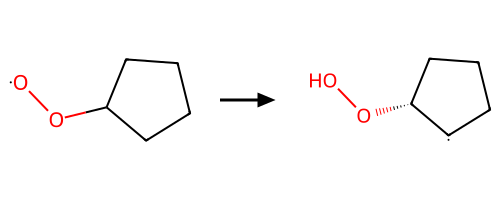

alt.LayerChart(...)

Median branching fraction: 0.0003338271744128077
[[2.55964657e-05 8.72870869e-05 3.68929763e-04 8.16493018e-04]
 [2.18990294e-05 4.73857816e-05 1.92266839e-04 6.15179626e-04]
 [4.05296126e-05 5.08297001e-05 1.33862481e-04 4.69352778e-04]
 [1.16457891e-04 9.33033383e-05 1.36855847e-04 3.81746568e-04]
 [3.87978493e-04 2.16947218e-04 1.95926256e-04 3.59829037e-04]
 [1.31973072e-03 5.29489502e-04 3.33827174e-04 4.01030202e-04]
 [           nan 1.19089865e-03 5.79186843e-04 4.97517923e-04]]

(6, 8) S(719) = S(722)r1


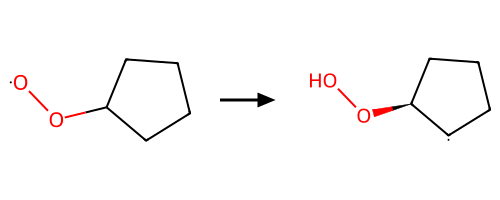

alt.LayerChart(...)

Median branching fraction: 0.0003338271744128077
[[2.55964657e-05 8.72870869e-05 3.68929763e-04 8.16493018e-04]
 [2.18990294e-05 4.73857816e-05 1.92266839e-04 6.15179626e-04]
 [4.05296126e-05 5.08297001e-05 1.33862481e-04 4.69352778e-04]
 [1.16457891e-04 9.33033383e-05 1.36855847e-04 3.81746568e-04]
 [3.87978493e-04 2.16947218e-04 1.95926256e-04 3.59829037e-04]
 [1.31973072e-03 5.29489502e-04 3.33827174e-04 4.01030202e-04]
 [           nan 1.19089865e-03 5.79186843e-04 4.97517923e-04]]

(6, 9) S(719) = S(725)r0


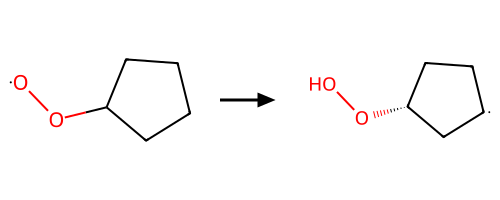

alt.LayerChart(...)

Median branching fraction: 0.023091410888779827
[[0.06745422 0.06403772 0.0611266  0.06018117]
 [0.03606899 0.03415068 0.03136724 0.03025772]
 [0.02746269 0.02309141 0.02064659 0.01934945]
 [0.0303099  0.01914357 0.01601907 0.01446911]
 [0.04306181 0.01892828 0.01380995 0.01202356]
 [0.07592159 0.02297372 0.01321216 0.01081296]
 [       nan 0.03067466 0.01356654 0.0101433 ]]

(6, 10) S(719) = S(725)r1


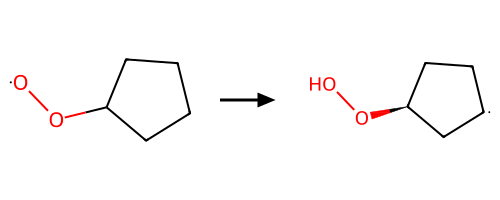

alt.LayerChart(...)

Median branching fraction: 0.023091410888779827
[[0.06745422 0.06403772 0.0611266  0.06018117]
 [0.03606899 0.03415068 0.03136724 0.03025772]
 [0.02746269 0.02309141 0.02064659 0.01934945]
 [0.0303099  0.01914357 0.01601907 0.01446911]
 [0.04306181 0.01892828 0.01380995 0.01202356]
 [0.07592159 0.02297372 0.01321216 0.01081296]
 [       nan 0.03067466 0.01356654 0.0101433 ]]

(6, 2) S(719) = C5H8(522) + HO2(8)


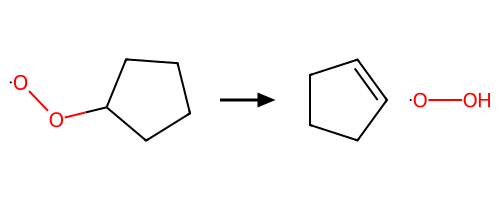

alt.LayerChart(...)

Median branching fraction: 0.009797887716083375
[[0.00680594 0.00703678 0.00713044 0.00696148]
 [0.00748646 0.00788972 0.00825196 0.00819374]
 [0.00816153 0.00861195 0.00930117 0.00954452]
 [0.00979789 0.00952177 0.01032789 0.0109767 ]
 [0.01429061 0.01092744 0.01137894 0.01247115]
 [0.02965687 0.0143531  0.0128246  0.01391129]
 [       nan 0.02084073 0.01474578 0.01538033]]

(7, 11) S(722)r0 = S(728)e


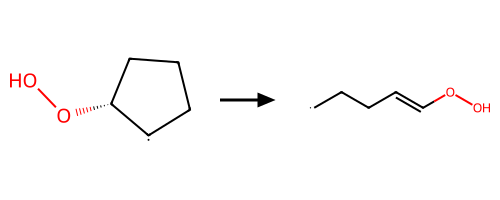

alt.LayerChart(...)

Median branching fraction: 2.145708888552074e-08
[[           nan            nan            nan 3.67653373e-09]
 [           nan            nan 1.08101550e-09 4.12389135e-08]
 [           nan            nan 5.51322169e-09 2.15862211e-07]
 [1.50868667e-11 3.98630629e-10 2.14570889e-08 7.21825186e-07]
 [1.29893747e-10 2.71108941e-09 7.63525958e-08 1.85808345e-06]
 [9.52584918e-10 1.70222224e-08 2.70590121e-07 4.20547298e-06]
 [5.87320875e-09 9.32547632e-08 9.42758628e-07 8.91902565e-06]]

(7, 12) S(722)r0 = S(728)z


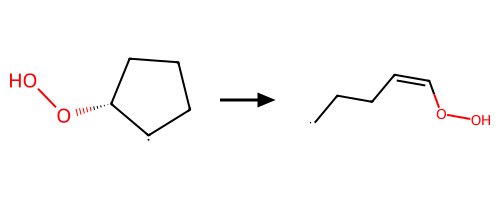

alt.LayerChart(...)

Median branching fraction: 1.6803161617824105e-09
[[           nan            nan            nan 1.61310637e-10]
 [           nan            nan 3.41069063e-11 2.35121143e-09]
 [           nan            nan 2.16624056e-10 1.48697097e-08]
 [           nan 1.25219926e-11 1.00942089e-09 5.74905015e-08]
 [4.59152335e-12 1.05488523e-10 4.16170801e-09 1.66539331e-07]
 [3.95890796e-11 7.70970739e-10 1.68815926e-08 4.14019956e-07]
 [3.76000521e-10 5.78179532e-09 6.82594796e-08 9.51362736e-07]]

(7, 13) S(722)r0 = S(731)r0


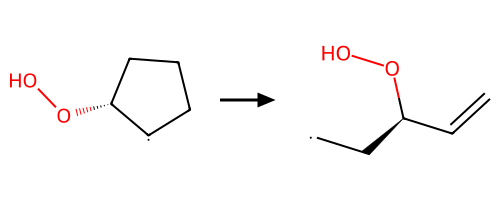

alt.LayerChart(...)

Median branching fraction: 1.7407707734737976e-08
[[           nan            nan 1.90974447e-10 4.41619140e-09]
 [           nan            nan 1.49393205e-09 4.44282539e-08]
 [           nan 7.91687779e-11 6.91709432e-09 2.15503039e-07]
 [2.24588583e-11 5.59874479e-10 2.49321444e-08 6.81368907e-07]
 [1.69003954e-10 3.39487495e-09 8.29064667e-08 1.67915689e-06]
 [9.43845607e-10 1.74077077e-08 2.72609450e-07 3.66463610e-06]
 [5.27149276e-09 8.65937087e-08 8.85093449e-07 7.53162166e-06]]

(7, 2) S(722)r0 = C5H8(522) + HO2(8)


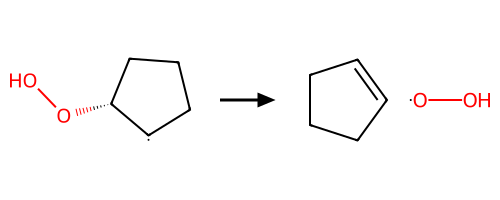

alt.LayerChart(...)

Median branching fraction: 0.16481990011744324
[[0.00543954 0.02373231 0.06012806 0.0905428 ]
 [0.01189667 0.03840307 0.09454137 0.15501678]
 [0.03159334 0.06418549 0.13183387 0.21711931]
 [0.07117687 0.1101833  0.17684171 0.2736122 ]
 [0.12937028 0.17462302 0.23593935 0.32660978]
 [0.1966345  0.24752218 0.30269746 0.37951829]
 [0.26256698 0.31573398 0.36691147 0.43075591]]

(7, 24) S(722)r0 = C5H8O(825)rs + OH(4)


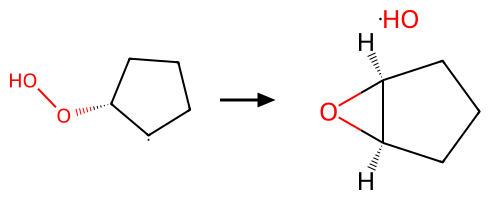

alt.LayerChart(...)

Median branching fraction: 0.8350275828358997
[[0.99452335 0.97621697 0.93978871 0.90934385]
 [0.98806452 0.9615353  0.90534429 0.84480436]
 [0.96835827 0.93573606 0.86802096 0.7826352 ]
 [0.92875866 0.88971413 0.8229814  0.72608374]
 [0.8705437  0.82525081 0.76385365 0.67303912]
 [0.80324495 0.75232948 0.69707246 0.62009746]
 [0.73725929 0.6840903  0.63284182 0.56883564]]

(8, 11) S(722)r1 = S(728)e


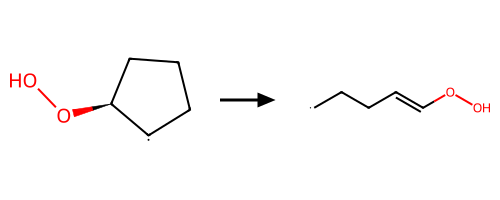

alt.LayerChart(...)

Median branching fraction: 2.145708888552074e-08
[[           nan            nan            nan 3.67653373e-09]
 [           nan            nan 1.08101550e-09 4.12389135e-08]
 [           nan            nan 5.51322169e-09 2.15862211e-07]
 [1.50868667e-11 3.98630629e-10 2.14570889e-08 7.21825186e-07]
 [1.29893747e-10 2.71108941e-09 7.63525958e-08 1.85808345e-06]
 [9.52584918e-10 1.70222224e-08 2.70590121e-07 4.20547298e-06]
 [5.87320875e-09 9.32547632e-08 9.42758628e-07 8.91902565e-06]]

(8, 12) S(722)r1 = S(728)z


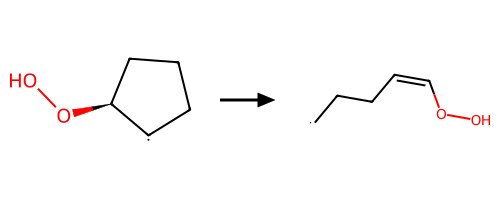

alt.LayerChart(...)

Median branching fraction: 1.6803161617824105e-09
[[           nan            nan            nan 1.61310637e-10]
 [           nan            nan 3.41069063e-11 2.35121143e-09]
 [           nan            nan 2.16624056e-10 1.48697097e-08]
 [           nan 1.25219926e-11 1.00942089e-09 5.74905015e-08]
 [4.59152335e-12 1.05488523e-10 4.16170801e-09 1.66539331e-07]
 [3.95890796e-11 7.70970739e-10 1.68815926e-08 4.14019956e-07]
 [3.76000521e-10 5.78179532e-09 6.82594796e-08 9.51362736e-07]]

(8, 14) S(722)r1 = S(731)r1


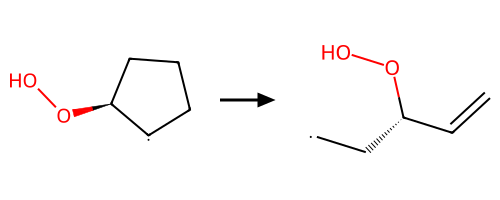

alt.LayerChart(...)

Median branching fraction: 1.7407707734737976e-08
[[           nan            nan 1.90974447e-10 4.41619140e-09]
 [           nan            nan 1.49393205e-09 4.44282539e-08]
 [           nan 7.91687779e-11 6.91709432e-09 2.15503039e-07]
 [2.24588583e-11 5.59874479e-10 2.49321444e-08 6.81368907e-07]
 [1.69003954e-10 3.39487495e-09 8.29064667e-08 1.67915689e-06]
 [9.43845607e-10 1.74077077e-08 2.72609450e-07 3.66463610e-06]
 [5.27149276e-09 8.65937087e-08 8.85093449e-07 7.53162166e-06]]

(8, 2) S(722)r1 = C5H8(522) + HO2(8)


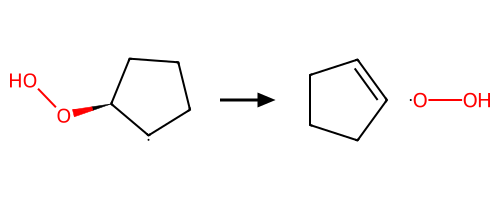

alt.LayerChart(...)

Median branching fraction: 0.16481990011744324
[[0.00543954 0.02373231 0.06012806 0.0905428 ]
 [0.01189667 0.03840307 0.09454137 0.15501678]
 [0.03159334 0.06418549 0.13183387 0.21711931]
 [0.07117687 0.1101833  0.17684171 0.2736122 ]
 [0.12937028 0.17462302 0.23593935 0.32660978]
 [0.1966345  0.24752218 0.30269746 0.37951829]
 [0.26256698 0.31573398 0.36691147 0.43075591]]

(8, 24) S(722)r1 = C5H8O(825)rs + OH(4)


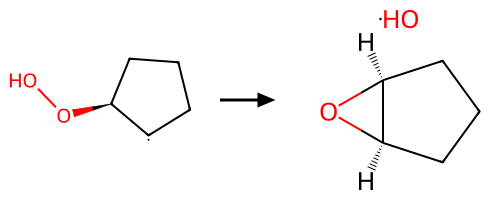

alt.LayerChart(...)

Median branching fraction: 0.8350275828358997
[[0.99452335 0.97621697 0.93978871 0.90934385]
 [0.98806452 0.9615353  0.90534429 0.84480436]
 [0.96835827 0.93573606 0.86802096 0.7826352 ]
 [0.92875866 0.88971413 0.8229814  0.72608374]
 [0.8705437  0.82525081 0.76385365 0.67303912]
 [0.80324495 0.75232948 0.69707246 0.62009746]
 [0.73725929 0.6840903  0.63284182 0.56883564]]

(9, 7) S(725)r0 = S(722)r0


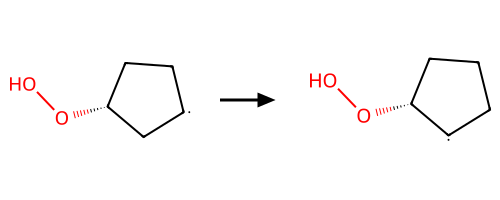

alt.LayerChart(...)

Median branching fraction: 1.1120342760736295e-05
[[1.40929093e-07 3.40049631e-07 7.10983386e-07 4.43213545e-07]
 [6.65778094e-07 9.24453770e-07 2.04030070e-06 2.42842586e-06]
 [3.90051759e-06 2.96928906e-06 4.79891144e-06 7.84962426e-06]
 [2.23079185e-05 1.07957201e-05 1.11203428e-05 1.89154922e-05]
 [1.08199719e-04 3.75636042e-05 2.58117217e-05 3.88067446e-05]
 [4.28252941e-04 1.12476744e-04 5.64169990e-05 6.97166128e-05]
 [           nan 2.43032108e-04 1.01279358e-04 1.11591495e-04]]

(9, 16) S(725)r0 = S(734)r1


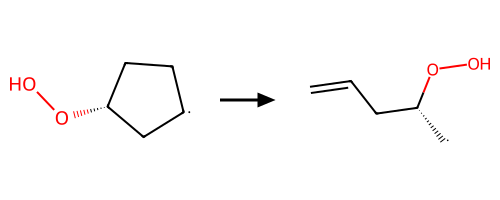

alt.LayerChart(...)

Median branching fraction: 0.00020806018723870892
[[8.03059638e-08 8.81389586e-07 1.71892369e-06 1.91813288e-06]
 [6.36405531e-07 1.00149158e-05 3.01898152e-05 3.97675107e-05]
 [3.30487204e-06 4.93463512e-05 2.08060187e-04 3.55072847e-04]
 [1.69427229e-05 1.77358260e-04 8.00664679e-04 1.76978781e-03]
 [8.18433769e-05 5.91314051e-04 2.25852565e-03 5.79045519e-03]
 [3.41069456e-04 1.89467868e-03 5.43177619e-03 1.36558314e-02]
 [1.16337512e-03 5.24758532e-03 1.18808478e-02            nan]]

(9, 23) S(725)r0 = C5H8O(833) + OH(4)


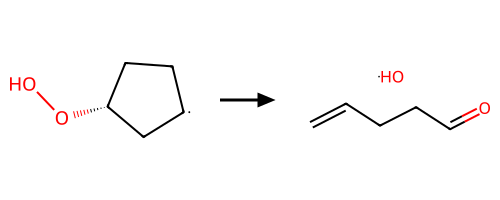

alt.LayerChart(...)

Median branching fraction: 0.004242147848054333
[[       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan 0.00035989 0.00080519 0.00087787]
 [       nan 0.00145999 0.00387623        nan]
 [       nan 0.00443486 0.01313513        nan]
 [0.00140356        nan 0.03398222 0.04495643]
 [0.00404944 0.02367165 0.06887848 0.09734212]]

(9, 25) S(725)r0 = C5H8O(829)rs + OH(4)


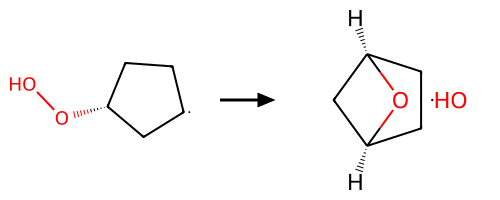

alt.LayerChart(...)

Median branching fraction: 0.013604055942536534
[[0.00026139 0.00054467 0.00062276 0.00062935]
 [0.00090729 0.00236816 0.00296239 0.00303798]
 [0.00228651 0.00669667 0.00918876 0.00953607]
 [0.00529584 0.01506738 0.02196427 0.02299308]
 [0.01214073 0.02946446 0.04389511 0.0461403 ]
 [0.02664142 0.05360008 0.07664577 0.07852103]
 [0.0503354  0.08489692 0.11518579 0.11845866]]

(10, 8) S(725)r1 = S(722)r1


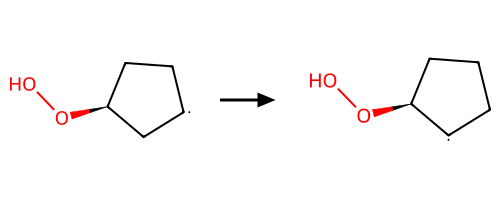

alt.LayerChart(...)

Median branching fraction: 1.1120342760736295e-05
[[1.40929093e-07 3.40049631e-07 7.10983386e-07 4.43213545e-07]
 [6.65778094e-07 9.24453770e-07 2.04030070e-06 2.42842586e-06]
 [3.90051759e-06 2.96928906e-06 4.79891144e-06 7.84962426e-06]
 [2.23079185e-05 1.07957201e-05 1.11203428e-05 1.89154922e-05]
 [1.08199719e-04 3.75636042e-05 2.58117217e-05 3.88067446e-05]
 [4.28252941e-04 1.12476744e-04 5.64169990e-05 6.97166128e-05]
 [           nan 2.43032108e-04 1.01279358e-04 1.11591495e-04]]

(10, 17) S(725)r1 = S(734)r0


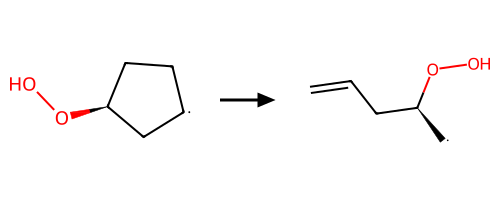

alt.LayerChart(...)

Median branching fraction: 0.00020806018723870892
[[8.03059638e-08 8.81389586e-07 1.71892369e-06 1.91813288e-06]
 [6.36405531e-07 1.00149158e-05 3.01898152e-05 3.97675107e-05]
 [3.30487204e-06 4.93463512e-05 2.08060187e-04 3.55072847e-04]
 [1.69427229e-05 1.77358260e-04 8.00664679e-04 1.76978781e-03]
 [8.18433769e-05 5.91314051e-04 2.25852565e-03 5.79045519e-03]
 [3.41069456e-04 1.89467868e-03 5.43177619e-03 1.36558314e-02]
 [1.16337512e-03 5.24758532e-03 1.18808478e-02            nan]]

(10, 23) S(725)r1 = C5H8O(833) + OH(4)


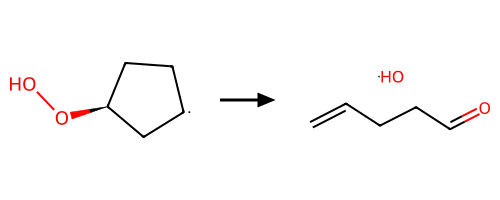

alt.LayerChart(...)

Median branching fraction: 0.004242147848054333
[[       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan 0.00035989 0.00080519 0.00087787]
 [       nan 0.00145999 0.00387623        nan]
 [       nan 0.00443486 0.01313513        nan]
 [0.00140356        nan 0.03398222 0.04495643]
 [0.00404944 0.02367165 0.06887848 0.09734212]]

(10, 25) S(725)r1 = C5H8O(829)rs + OH(4)


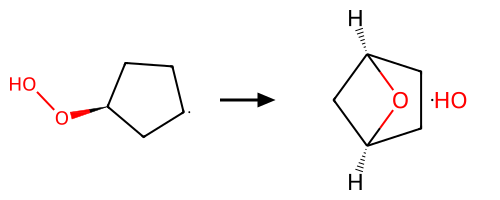

alt.LayerChart(...)

Median branching fraction: 0.013604055942536534
[[0.00026139 0.00054467 0.00062276 0.00062935]
 [0.00090729 0.00236816 0.00296239 0.00303798]
 [0.00228651 0.00669667 0.00918876 0.00953607]
 [0.00529584 0.01506738 0.02196427 0.02299308]
 [0.01214073 0.02946446 0.04389511 0.0461403 ]
 [0.02664142 0.05360008 0.07664577 0.07852103]
 [0.0503354  0.08489692 0.11518579 0.11845866]]

(11, 31) S(728)e = C2H4(52) + C3H4O(165) + OH(4)


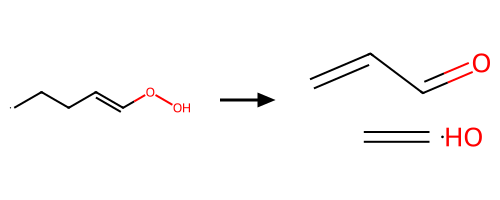

alt.LayerChart(...)

Median branching fraction: 0.9999806799849207
[[1.         1.         1.                nan]
 [1.         1.         0.99569126 0.73402418]
 [0.99999695 0.99999241 0.99917387 0.92604585]
 [0.99999602 0.99999234 0.99971518 0.97858772]
 [0.99999455 0.99998927 0.99982579 0.99220164]
 [0.99999255 0.99998068 0.99983053 0.99625504]
 [0.99999015 0.99996069 0.99978005 0.99769918]]

(12, 31) S(728)z = C2H4(52) + C3H4O(165) + OH(4)


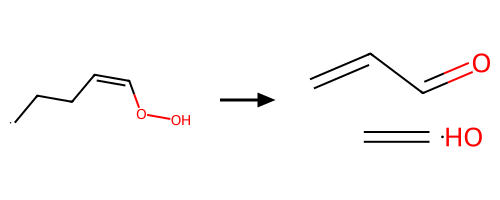

alt.LayerChart(...)

Median branching fraction: 0.9999990090644261
[[1.         1.         1.                nan]
 [1.         1.         0.99992998 0.98957225]
 [1.         0.99999976 0.99998089 0.99684276]
 [0.99999981 0.99999967 0.99999104 0.99889164]
 [0.9999997  0.99999947 0.99999287 0.99951447]
 [0.99999955 0.99999901 0.99999127 0.9997261 ]
 [0.99999932 0.99999759 0.99998592 0.99980369]]

(13, 31) S(731)r0 = C2H4(52) + C3H4O(165) + OH(4)


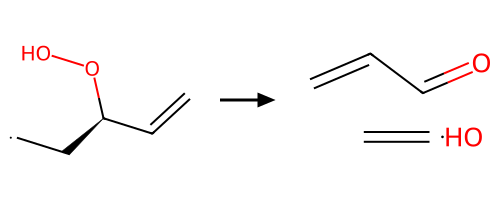

alt.LayerChart(...)

Median branching fraction: 0.9999862822394616
[[1.         1.         0.98965362        nan]
 [1.         1.         0.99887213 0.93262032]
 [1.         0.99999765 0.99978464 0.98463687]
 [0.99999885 0.99999742 0.99992219 0.99578489]
 [0.99999838 0.99999599 0.99994792 0.99845322]
 [0.99999797 0.99999303 0.99994566 0.99923184]
 [0.99999749 0.99998628 0.99992667 0.99949499]]

(14, 31) S(731)r1 = C2H4(52) + C3H4O(165) + OH(4)


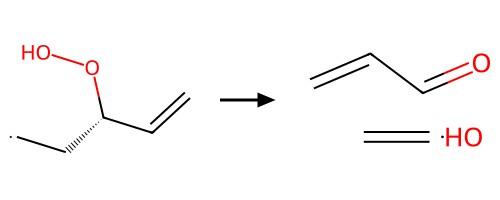

alt.LayerChart(...)

Median branching fraction: 0.9999862822394616
[[1.         1.         0.98965362        nan]
 [1.         1.         0.99887213 0.93262032]
 [1.         0.99999765 0.99978464 0.98463687]
 [0.99999885 0.99999742 0.99992219 0.99578489]
 [0.99999838 0.99999599 0.99994792 0.99845322]
 [0.99999797 0.99999303 0.99994566 0.99923184]
 [0.99999749 0.99998628 0.99992667 0.99949499]]

(16, 26) S(734)r1 = C2H4O2(58) + C3H5(122)


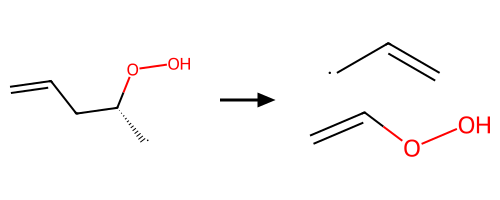

alt.LayerChart(...)

Median branching fraction: 0.0012051105856835736
[[9.05857504e-05 2.50235876e-04 4.23905012e-04 4.91716699e-04]
 [1.49587531e-04 4.47804037e-04 9.08422630e-04 1.20511059e-03]
 [2.18446185e-04 6.71774593e-04 1.51902115e-03 2.30844211e-03]
 [3.08198472e-04 9.12894046e-04 2.18252373e-03 3.72361301e-03]
 [4.98661582e-04 1.21517228e-03 2.86758798e-03 5.30773853e-03]
 [9.06161573e-04 1.70772684e-03 3.65313279e-03 6.99441965e-03]
 [1.61780030e-03 2.58574535e-03 4.65007644e-03            nan]]

(16, 27) S(734)r1 = C5H8(524) + HO2(8)


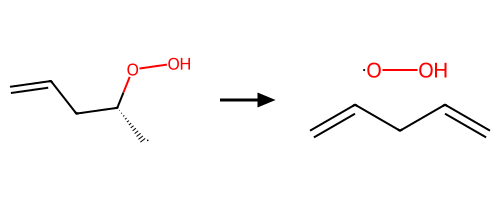

alt.LayerChart(...)

Median branching fraction: 0.99626644069195
[[0.99943876 0.99692205 0.99557855 0.99534169]
 [0.99958717 0.99752498 0.9957642  0.99526709]
 [0.99959992 0.9978355  0.99564193 0.99457727]
 [0.99954457 0.99794029 0.99535106 0.99343882]
 [0.9993795  0.99785287 0.99497295 0.99207505]
 [0.9989809  0.99751603 0.99446393 0.99056793]
 [0.99826752 0.99676868 0.99371497 0.98900957]]

(17, 26) S(734)r0 = C2H4O2(58) + C3H5(122)


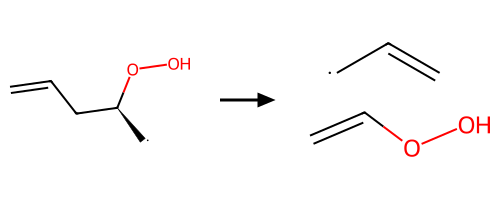

alt.LayerChart(...)

Median branching fraction: 0.0012051105856835736
[[9.05857504e-05 2.50235876e-04 4.23905012e-04 4.91716699e-04]
 [1.49587531e-04 4.47804037e-04 9.08422630e-04 1.20511059e-03]
 [2.18446185e-04 6.71774593e-04 1.51902115e-03 2.30844211e-03]
 [3.08198472e-04 9.12894046e-04 2.18252373e-03 3.72361301e-03]
 [4.98661582e-04 1.21517228e-03 2.86758798e-03 5.30773853e-03]
 [9.06161573e-04 1.70772684e-03 3.65313279e-03 6.99441965e-03]
 [1.61780030e-03 2.58574535e-03 4.65007644e-03            nan]]

(17, 27) S(734)r0 = C5H8(524) + HO2(8)


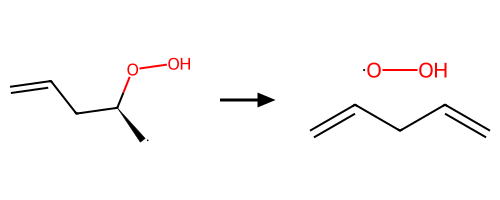

alt.LayerChart(...)

Median branching fraction: 0.99626644069195
[[0.99943876 0.99692205 0.99557855 0.99534169]
 [0.99958717 0.99752498 0.9957642  0.99526709]
 [0.99959992 0.9978355  0.99564193 0.99457727]
 [0.99954457 0.99794029 0.99535106 0.99343882]
 [0.9993795  0.99785287 0.99497295 0.99207505]
 [0.9989809  0.99751603 0.99446393 0.99056793]
 [0.99826752 0.99676868 0.99371497 0.98900957]]

(2, 3) C5H8(522) + HO2(8) = C5H7(504) + H2O2(10)


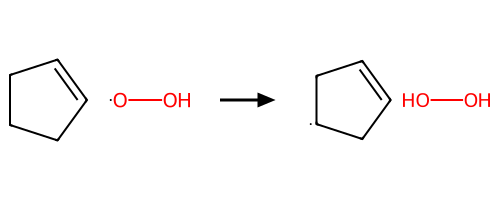

alt.LayerChart(...)

Median branching fraction: 0.06241990395748057
[[0.01993651 0.01987161 0.01937323 0.01918741]
 [0.03210731 0.03201361 0.0315489  0.03137536]
 [0.04639974 0.04642284 0.04624664 0.04709635]
 [0.06210545 0.0622761  0.06256371 0.06508062]
 [0.07824023 0.07866773 0.07957225 0.08399417]
 [0.09435255 0.09481845 0.09654897 0.10250094]
 [0.10959738 0.11048771 0.11243418 0.11961654]]

(2, 5) C5H8(522) + HO2(8) = C5H7(1202) + H2O2(10)


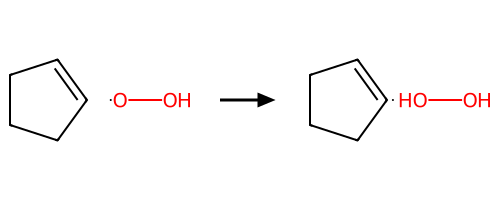

alt.LayerChart(...)

Median branching fraction: 0.0004238513665265582
[[5.63932096e-06 5.62127619e-06 5.49454728e-06 5.49556109e-06]
 [3.64478820e-05 3.62322942e-05 3.59015415e-05 3.62410574e-05]
 [1.44958391e-04 1.45393959e-04 1.44846553e-04 1.50901873e-04]
 [4.20417254e-04 4.22599141e-04 4.25103592e-04 4.58047586e-04]
 [9.71717988e-04 9.78757201e-04 9.99582029e-04 1.09963903e-03]
 [1.91271267e-03 1.92805678e-03 1.99197776e-03 2.22781556e-03]
 [3.31787922e-03 3.37439372e-03 3.50237879e-03 3.95566443e-03]]

(2, 30) C5H8(522) + HO2(8) = C5H7(500) + H2O2(10)


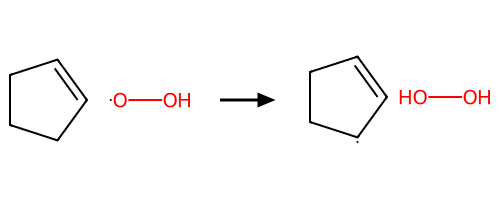

alt.LayerChart(...)

Median branching fraction: 0.6084770319468379
[[0.48511448 0.48299025 0.47131539 0.45895463]
 [0.52612059 0.52394254 0.51544911 0.50368358]
 [0.56878285 0.56786415 0.56217529 0.55962724]
 [0.60873341 0.60822065 0.60562725 0.61412306]
 [0.64015077 0.64022412 0.63994937 0.65690393]
 [0.66479504 0.66636211 0.66607829 0.68794516]
 [0.6835972  0.68441159 0.68567449 0.70989691]]

(28, 6) C5H9(553) + O2(6) = S(719)


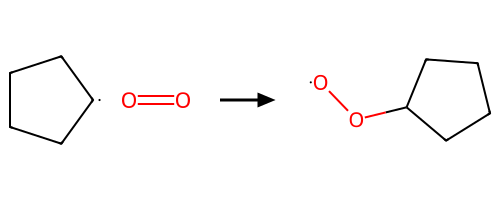

alt.LayerChart(...)

Median branching fraction: 0.9682772565096291
[[0.98217325 0.99364923 0.99885816 0.9998402 ]
 [0.96827726 0.984116   0.99623666 0.99940311]
 [0.94105469 0.96491936 0.98991426 0.99817813]
 [0.88463634 0.92059742 0.9753551  0.99512195]
 [0.7383842  0.81677597 0.94140944 0.98845191]
 [0.46467699 0.60098836 0.85794008 0.97366925]
 [       nan 0.33287858 0.68836616 0.94316977]]



In [79]:
label_dct = mess.surf.node_label_dict(surf_out)
obj_col = automech.util.df_.c_.temp()

print("Direct rates:")
for rate_key in mess.surf.rate_keys(
    surf_out, P_vals=[1.0], empty=False, well_skipping=False
):
    eq = mess.surf.edge_chemkin_equation(surf_out, rate_key)
    print(rate_key, eq)

    rate = surf_out.rates[rate_key]
    rate_fit = surf_out.rate_fits[rate_key]

    amchis = list(mit.unique_everseen(automech.reaction_amchis(mech, eq=eq)))
    for amchi in amchis:
        automol.amchi.display_reaction(*amchi)

    ref_rates = ref_labels = []
    if compare and amchis:
        ref_rates = [r.rate for r in automech.reaction_rate_objects(mech, eq)]
        ref_labels = [f"Ref {i}" for i, _ in enumerate(ref_rates)]

    display(
        ac.rate.data.display(
            [rate, rate_fit, *ref_rates],
            T_range=T_range,
            label=["Data", "Fit", *ref_labels],
            check_order=False,
        )
    )

    branch_frac_arr = branch_frac_dct[rate_key]
    branch_frac = np.nanmedian(branch_frac_arr)
    print(f"Median branching fraction: {branch_frac}")
    print(branch_frac_arr)
    print()

In [80]:
print("Well-skipping rates:")
for rate_key in mess.surf.rate_keys(surf_out, direct=False):
    print(rate_key)
    rate = surf_out.rates[rate_key]
    rate_fit = surf_out.rate_fits[rate_key]
    display(
        ac.rate.data.display([rate, rate_fit], T_range=T_range, label=["Data", "Fit"])
    )

    branch_frac_arr = branch_frac_dct[rate_key]
    branch_frac = np.nanmedian(branch_frac_arr)
    print(f"Median branching fraction: {branch_frac}")
    print(branch_frac_arr)
    print()

Well-skipping rates:
(9, 10)


alt.LayerChart(...)

Median branching fraction: 0.003920008927319601
[[2.21235057e-03 8.03970231e-04 1.26206689e-04 1.31091330e-05]
 [4.01425028e-03 2.32992414e-03 5.75597027e-04 7.54604813e-05]
 [6.24467101e-03 4.26250379e-03 1.66834639e-03 2.93134406e-04]
 [1.05750829e-02 6.01475837e-03 3.33610283e-03 8.43834829e-04]
 [1.89580703e-02 7.61885412e-03 5.01051068e-03 1.84866775e-03]
 [3.51608119e-02 9.72686211e-03 6.14026873e-03 3.01865746e-03]
 [           nan 1.13432652e-02 6.37865187e-03 3.92000893e-03]]

(2, 24)


alt.LayerChart(...)

Median branching fraction: 0.2639021706668597
[[0.49189132 0.46948405 0.32420656 0.07151758]
 [0.4394875  0.42923275 0.35527567 0.12415918]
 [0.38228735 0.37498955 0.33698234 0.16322434]
 [0.32583469 0.31984154 0.29759541 0.17407283]
 [0.27730473 0.27150126 0.25630308 0.16624977]
 [0.23553769 0.22911264 0.21825976 0.14887806]
 [0.200597   0.19556421 0.18633966 0.13023   ]]

(23, 25)


alt.LayerChart(...)

Median branching fraction: 0.11399741115556601
[[       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan 0.11839595 0.05157682 0.005664  ]
 [0.16457154 0.15060625 0.08212768 0.01195945]
 [0.18394187 0.17414354 0.11399741 0.02101224]]

(23, 26)


alt.LayerChart(...)

Median branching fraction: 0.001567605117180775
[[       nan        nan        nan        nan]
 [       nan 0.0238837         nan        nan]
 [       nan 0.00147599        nan        nan]
 [       nan 0.00050644        nan        nan]
 [0.00081657 0.00082215        nan        nan]
 [0.00246857 0.00165922 0.00108409        nan]
 [0.00337227 0.00322088 0.00241233 0.00075148]]

(23, 27)


alt.LayerChart(...)

Median branching fraction: 0.0626603771059666
[[       nan 1.                nan        nan]
 [       nan 0.12940331 1.                nan]
 [       nan 0.00311124 0.02578512        nan]
 [       nan 0.03372344 0.00859743        nan]
 [0.08239923 0.06250919 0.0287401  0.003616  ]
 [0.11583305 0.10848756 0.06266038 0.01157764]
 [0.17321193 0.16643807 0.1142916  0.02903774]]

(26, 27)


alt.LayerChart(...)

Median branching fraction: 0.9267261254350051
[[0.95234566 0.68198666 0.22623434 0.03335301]
 [0.98793425 0.79528719 0.4589372  0.09640984]
 [0.99623165 0.94910769 0.68474331 0.21557318]
 [0.99809504 0.97886776 0.83181321 0.3820841 ]
 [0.99787511 0.98788063 0.90866456 0.55305276]
 [0.99724463 0.99068441 0.94478769 0.69284065]
 [0.99689467 0.99105753 0.96223722 0.78966835]]

(28, 9)


alt.LayerChart(...)

Median branching fraction: 0.016399640448410777
[[8.87402148e-03 3.17142359e-03 5.70776092e-04 7.98959067e-05]
 [1.55804613e-02 7.90001378e-03 1.87969181e-03 2.98406684e-04]
 [2.75258496e-02 1.72188196e-02 5.02130420e-03 9.10533222e-04]
 [4.57887771e-02 3.74124066e-02 1.21532342e-02 2.43378397e-03]
 [7.10891167e-02 7.74424627e-02 2.81322688e-02 5.73748025e-03]
 [7.89573102e-02 1.32472501e-01 6.37551801e-02 1.29343517e-02]
 [6.49350649e-02 1.51432469e-01 1.22173596e-01 2.71904799e-02]]

(28, 10)


alt.LayerChart(...)

Median branching fraction: 0.016399640448410777
[[8.87402148e-03 3.17142359e-03 5.70776092e-04 7.98959067e-05]
 [1.55804613e-02 7.90001378e-03 1.87969181e-03 2.98406684e-04]
 [2.75258496e-02 1.72188196e-02 5.02130420e-03 9.10533222e-04]
 [4.57887771e-02 3.74124066e-02 1.21532342e-02 2.43378397e-03]
 [7.10891167e-02 7.74424627e-02 2.81322688e-02 5.73748025e-03]
 [7.89573102e-02 1.32472501e-01 6.37551801e-02 1.29343517e-02]
 [6.49350649e-02 1.51432469e-01 1.22173596e-01 2.71904799e-02]]

(28, 23)


alt.LayerChart(...)

Median branching fraction: 0.0010203543303123172
[[           nan            nan            nan            nan]
 [           nan 6.90686919e-06            nan            nan]
 [3.45837597e-04 8.09367703e-05 7.93844283e-06            nan]
 [3.61639337e-03 8.61746445e-04 8.43759570e-05 3.91793729e-06]
 [2.65111347e-02 7.19972895e-03 7.21380524e-04 3.08426723e-05]
 [1.08424632e-01 4.20851267e-02 5.27357663e-03 2.11979653e-04]
 [2.31974922e-01 1.32605730e-01 2.71699489e-02 1.17896222e-03]]

(28, 25)


alt.LayerChart(...)

Median branching fraction: 0.000532369301256974
[[7.84015490e-05 7.87300352e-06 2.85056200e-07 4.15915263e-09]
 [5.53678540e-04 7.53887029e-05 3.87216514e-06 7.30695672e-08]
 [3.41132324e-03 5.32369301e-04 3.30449638e-05 7.64458373e-07]
 [1.85419778e-02 3.34189475e-03 2.22164217e-04 5.74327527e-06]
 [7.99261616e-02 1.76665618e-02 1.27459609e-03 3.21061071e-05]
 [2.11938043e-01 7.01418779e-02 6.57229326e-03 1.58086521e-04]
 [           nan 1.59072306e-01 2.51641138e-02 6.58519436e-04]]

(28, 27)


alt.LayerChart(...)

Median branching fraction: 3.189256355212561e-05
[[3.04129086e-07 4.53967542e-08 1.16809991e-09 6.61994656e-12]
 [8.14233148e-06 1.67480292e-06 8.23305015e-08 8.72120641e-10]
 [1.36452930e-04 2.96962251e-05 2.15198751e-06 3.83689935e-08]
 [1.62773087e-03 3.74124066e-04 3.18925636e-05 8.18843206e-07]
 [1.30002749e-02 3.47281044e-03 3.30043377e-04 1.01817979e-05]
 [5.70457121e-02 2.18396302e-02 2.70369190e-03 9.19776121e-05]
 [           nan 7.25784447e-02 1.49525894e-02 6.11785798e-04]]

